## Data Analysis - Inferential Statistics
There are time series techniques that can be performed on each to retrieve the following components of the time series. These are important aspects of each time series that I will investigate:
- Level
- Trend
- Seasonality
- Noise

I'll start by assessing the aforementioned qualities on the total demand. This will be a nice introduction to the techniques that I'll be using and how I'll be using them on a more refined scale for each individual station, later. 

We need a stationary time series before we can perform any type of forecasting. These components are necessary for forecasting:
- LIST OUT THE NECESSARY REQUIREMENTS from AILEEN NIELSEN'S TALK

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
# For time series analysis
from statsmodels.tsa import stattools

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Wrangling in one Step
# Specify columns to use
columns = ['bikeid', 'birth year', 'end station id', 
           'end station latitude', 'end station longitude', 'end station name',
           'gender', 'start station id', 'start station latitude', 'start station longitude',
           'start station name', 'starttime', 'stoptime', 'tripduration', 'usertype']

# use your path
path = r'/Users/vincent_zaballa/Springboard_Assignments/capstone_proj_2/CITI_BIKE/2016_data' 
all_files = glob.glob(os.path.join(path, "*.csv"))

# Appending all imported dataframes to empty df
frame = pd.DataFrame()
list_ = []
for file_ in all_files:
    df = pd.read_csv(file_, index_col=None, header=0)
    list_.append(df)
bike_df = pd.concat(list_)

# Naming columns for future use
bike_df.columns = columns + bike_df.columns[15:].tolist()

# Creating left and right dfs
right_df = bike_df[bike_df.iloc[:,0].notnull() == False]
left_df = bike_df[bike_df.iloc[:,0].notnull() == True]
right_df = right_df.dropna(axis=1, how='all')
left_df = left_df.dropna(axis=1, how='all')

# Convert individual dfs' timestamps
# Need to convert two different format dfs to timestamp beforehand to speed things up MASSIVELY
right_df.starttime = pd.to_datetime(right_df.starttime, format='%m/%d/%Y %H:%M:%S')
right_df.stoptime = pd.to_datetime(right_df.stoptime, format='%m/%d/%Y %H:%M:%S')
left_df.starttime = pd.to_datetime(left_df.starttime, format='%Y-%m-%d %H:%M:%S')
left_df.stoptime = pd.to_datetime(left_df.stoptime, format='%Y-%m-%d %H:%M:%S')

# Combining
frames = [right_df, left_df]
bike_df = pd.concat(frames, axis=0)

In [4]:
# Setting starttime as the index
bike_df.index = bike_df['starttime']
bike_df = bike_df.sort_index()

# Fixing Null Values
# Setting NaN values equal to average age
bike_df[bike_df['birth year'].notnull() == False] = np.ceil(bike_df['birth year'].mean()).astype(int)

# Converting the whole column to int to save space
bike_df.loc[:,'birth year'] = bike_df['birth year'].copy().astype(int)
bike_df.loc[:,'tripduration'] = bike_df['tripduration'].copy().astype(int)
bike_df.loc[:,'end station id'] = bike_df['end station id'].copy().astype(int)
bike_df.loc[:,'start station id'] = bike_df['start station id'].copy().astype(int)
bike_df.loc[:,'gender'] = bike_df['gender'].copy().astype(int)
bike_df.loc[:,'bikeid'] = bike_df['bikeid'].copy().astype(int)

# Create a one-time user gender class (unknown) instead of "Other" class
bike_df.loc[:,'gender'].loc[bike_df['usertype'] == 'Customer'] = 3

# Fixing a station's lat/lon
bike_df.loc[:, 'end station latitude'][bike_df['end station name'] == 'NYCBS Depot BAL - DYR'] = 40.75903008
bike_df.loc[:, 'end station longitude'][bike_df['end station name'] == 'NYCBS Depot BAL - DYR'] = -73.9938587

# Deleting anomalous (no data) station
bike_df = bike_df[bike_df['end station name'] != 'SSP - Basement']

# Removing the missing start station lat/lons
bike_df = bike_df[bike_df['start station longitude'] != 0]

# Creating distance travelled
# Distance travelled - vectorized
bike_df['LAT_start_rad'], bike_df['LON_start_rad'] = np.radians(bike_df['start station latitude']), np.radians(bike_df['start station longitude'])
bike_df['LAT_end_rad'], bike_df['LON_end_rad'] = np.radians(bike_df['end station latitude']), np.radians(bike_df['end station longitude'])
bike_df['dLON'] = bike_df['LON_end_rad'] - bike_df['LON_start_rad']
bike_df['dLAT'] = bike_df['LAT_end_rad'] - bike_df['LAT_start_rad']
bike_df['distance_miles'] = 3961 * 2 * np.arcsin(np.sqrt(
    np.sin(bike_df['dLAT']/2)**2 + np.cos(bike_df['LAT_start_rad']) * np.cos(bike_df['LAT_end_rad']) * np.sin(bike_df['dLON']/2)**2
))
del bike_df['LON_start_rad'], bike_df['LAT_start_rad'], bike_df['LAT_end_rad'], bike_df['LON_end_rad'], bike_df['dLON'], bike_df['dLAT']


# Average velocity - Assuming they went in a straight line and were moving the entire time...
bike_df['speed_miles/hour'] = bike_df['distance_miles'] / (bike_df['tripduration']/3600)

# deleting max speed data error (trip duration way too long)
bike_df = bike_df.loc[bike_df['speed_miles/hour'] != bike_df['speed_miles/hour'].max()]

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# Age to use as possible feature
bike_df['age'] = 2017 - bike_df.loc[:,'birth year']

# Simplify by making a univariate, total bike counts, dataframe
total_DayCounts_df = bike_df.resample('D').apply({'bikeid':'count'})
print('Number of Days (leap year!): ',len(total_DayCounts_df))
total_DayCounts_df.columns = ['ride_count']

Number of Days (leap year!):  366


Just as a review, here is the daily number of trips.

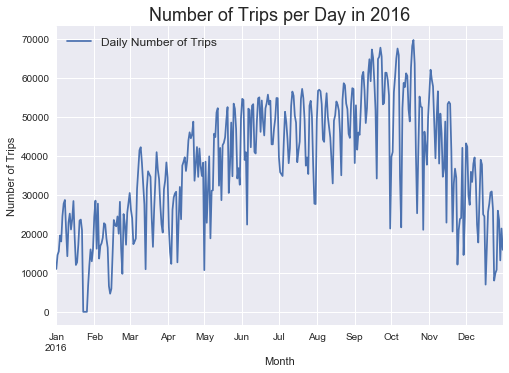

In [6]:
total_DayCounts_df.rename(columns={'ride_count': 'Daily Number of Trips'}).plot()
plt.legend(loc='best', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Day in 2016', fontsize=18)

## Autocorrelation Function (ACF)
Now, I'll plot the autocorrelation of this time series data to better understand if there are any signals that are statistically significant.

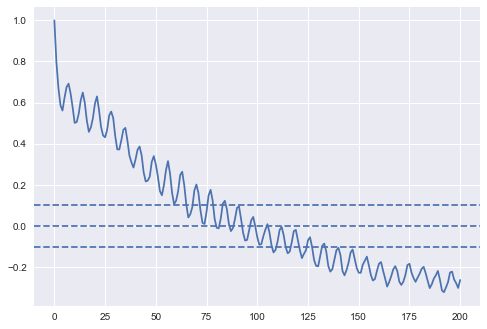

In [7]:
from statsmodels.tsa.stattools import acf
acf_result = acf(total_DayCounts_df, nlags=200)

plt.plot(acf_result)
plt.axhline(y=0, linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(total_DayCounts_df)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(total_DayCounts_df)),linestyle='--')

According to this ACF, it looks like everything is relevant, as is signified by the significance lines at y=1.96. However, we know this not to be the case. This means that every point nearby is closely correlated to a point nearby. Farther along the graph, we can see the ACF trend dip below the significance line for negative correlation, which means that, over the long-term, the graph will go up, which is slightly true.

Remember, at x=0 means that each data point correlates with itself, equally.

Autocorrelation is really looking for internal structure. There is an obvious trend in the original data, plotted before the ACF figure, that needs to be taken into account.

Now, I want to de-trend the data. This can be done in a variety of manners, such as applying a log transformation, local smoothing (the red smoothed line from the rolling window), or even a linear regression of the general trend. Each has its strengths and weaknesses, and place of use.

The goal of this is getting to **stationarity**. We want the variance and the mean to be fairly stable. Remember the individual stations? They all had very different variances and means.

The ACF is a good diagnostic to determine what kind of model we want to use to predict future events. 

## Pre-prediction Munging and Stationarity
Next is munging in order to get the data into a format suitable for an ARIMA model.

To use an ARIMA model, one of the most inclusive, general, and powerful ways of predicting future events, you need stationarity.

Stationarity:
- Constant mean
- Constant variance
- Constant autocorrelation

First method to try and create a stationary time series: Differencing. This can handle both the trend and seasonality of some datasets.

Other methods: Moving Average and Linear Regression. Calculating the moving average and subtracting that from the original dataset can be computationally taxing, but it is a very accurate measure. Linear regression is direct in its application, but is worse overall because there is still a sinusoidal trend in the data.

### Seasonality
There is additive and multiplicative seasonality. The simplest way to remove seasonality is to find the average de-trended values for a season... (how do you distinguish seasons?). However, the more common use is a loess, which is locally weighted scatterplot smoothing. 

To use loess method:
- Window of specified width is placed over the data
- A weighted regression line or curve is fitted to the data, with points closest to the center of the curve having greatest weight
- Weighting is reduced on points farthest from regression line/curve and calculation is rerun several times
    - This yields one point on loess curve
    - Helps reduce impact of outliers
    - Computationally taxing
    
## Testing Stationarity
Once I think I have a stationary dataset, I need to test that assumption with the Dickey-Fuller Test. This tests the null hypothesis of whether a unit root is present in an autoregressive model. Basically testing whether p=1.

$y_t = py_{t-1} + u_t$

The test gives back **several different values** to help assess significance with standard p-value reasoning. The basic intuition is that *p* having a unit value means it is not stationary.

# Forecasting
Thinking about Autoregressive Integrative Moving Average (ARIMA) models. Here are some of the components:

**Moving Average (MA)**

Takes the form:

$X_t = \mu + \epsilon_t + \theta_{1}\epsilon_{t-1} + \cdots + \theta_{q}\epsilon_{t-q}$

Where $\mu$ is the mean of the series, $\theta$ are parameters, and $\theta_q$ is not zero.

This is a stationary process regadless the parameter ($\theta$) values.

**Autoregressive Process (AR)**

Takes the form:

$X_t = \phi_1X_{t-1} + \cdots + \phi_pX_{t-p} + \epsilon_t$

This is a stationary process if $abs(\phi) < 1$

This is saying your value at a particular time depends on your past values. It's kind of like regressing on yourself.

**Differencing (I)**

This is the differencing from trying to detrend the data. The 'I' is optional, as there are also ARMA models that exclude it, but it can be seen as record-keeping.

## Stationarity
Remember, the time series must be stationary in order for an ARIMA model to work. If it cannot be made stationary, then an ARIMA model cannot be used. ARIMA models can be seen as a combination of signal and noise, where we want to extract the signal to produce future predictions.

## Applying the Appropriate ARIMA Model
To determine what ARIMA model to use, I'll plot the data, the ACF, and PACF. I'll use the plots to determine how to detrend the data. After that, most software will use a maximum likelihood estimation to determine the appropriate ARIMA parameters. This can include an AIC and BIC. 
- Use PACF for AR model diagnostics
- Use ACF for MA model diagnostics

If it's an AR(1) process, you can only get the next set of observations, so watch out for this. However, the higher the order, the more likely you're overfitting your data.

If a basic ARIMA model does not work very well for the data, then it is possible to go to a seasonal ARIMA model, where the seasonality is measured and labeled, and the autoregressive term is improved. Info in Aileen Nielsen's video.

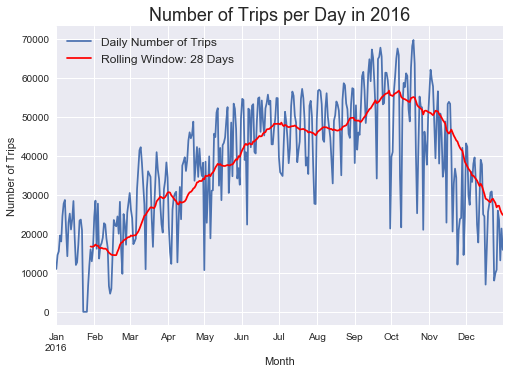

In [8]:
# Total number of rides per day
total_DayCounts_df.rename(columns={'ride_count': 'Daily Number of Trips'}).plot()
# Create the rolling class
r = total_DayCounts_df.rolling(window = 28)
r.mean()['ride_count'][28:].plot(color='red', label='Rolling Window: 28 Days')
plt.legend(loc='best', fontsize=12)
#plt.xlim(['2016-01-01 00:00:41', '2016-12-31 23:59:56'])
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Day in 2016', fontsize=18)

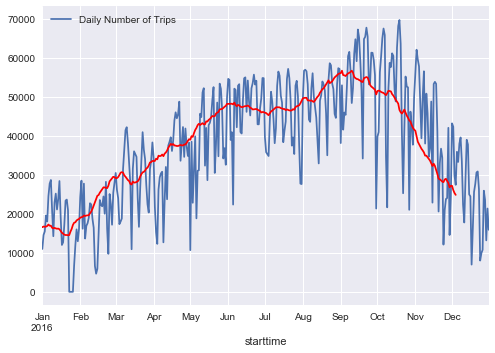

In [9]:
# Shifting the values back by 28 days
M_roll_mean = r.mean()['ride_count']
M_roll_mean = M_roll_mean[27:]
M_roll_mean.index = total_DayCounts_df.index[:-27]
total_DayCounts_df.rename(columns={'ride_count': 'Daily Number of Trips'}).plot()
M_roll_mean.plot(color='red', label='Rolling Window')

In [10]:
# Creating MA from original plot
M_roll_mean2 = r.mean()['ride_count']
M_roll_mean2 = M_roll_mean2[27:]
M_roll_mean2.index = total_DayCounts_df.index[27:]

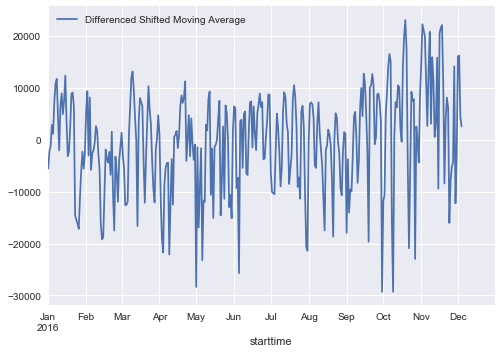

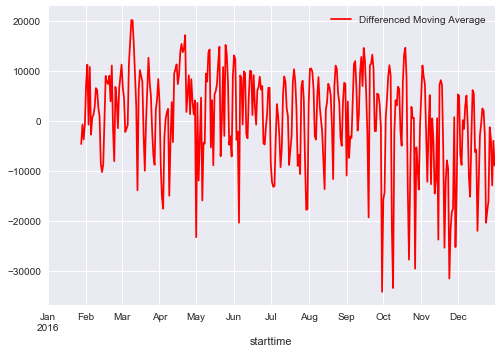

In [11]:
MA_diff = total_DayCounts_df - M_roll_mean.to_frame()
MA_diff2 = total_DayCounts_df - M_roll_mean2.to_frame()
MA_diff[:-27]
MA_diff2[27:]
# plt.plot(MA_diff.index, MA_diff, 'r', MA_diff2.index, MA_diff2, 'b', alpha=0.6)
MA_diff.rename(columns={'ride_count': 'Differenced Shifted Moving Average'}).plot()
MA_diff2.rename(columns={'ride_count': 'Differenced Moving Average'}).plot(color='r')


Looks like subtracting by the MA can be pretty effective in centering the mean around zero. However, there are two ways this can be done, by using the MA as it is, which is most similar to the trends of the original plot, or by moving it back 28 days and then subtracting. I've plotted both and they each have their advantages.

The red plot appears to stay closer to a mean of zero, while the blue plot seems to 'wander' about the mean of zero. Remember, the question is which plot centers the data around the mean of zero, not which has less variance or seasonality. In this case, it appears that the MA which was shifted backwards appears to do a better job than the original MA calculation. 

Looks like it's time for a moving average of the difference between the original plots and the moving average.

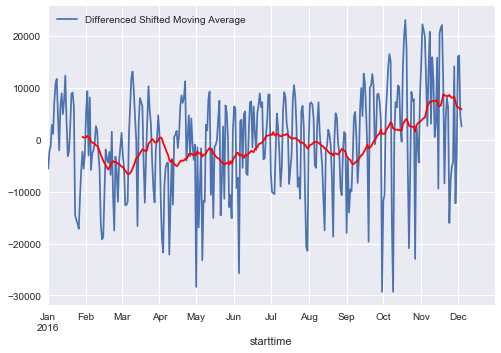

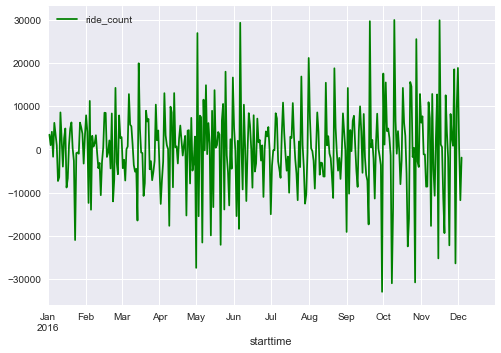

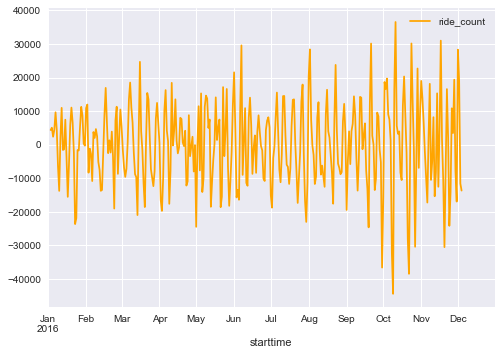

In [33]:
# plt.plot(MA_diff.index, MA_diff, 'r', MA_diff2.index, MA_diff2, 'b', alpha=0.6)
MA_diff_shift = MA_diff - MA_diff.shift(periods=1)
MA_diff.rename(columns={'ride_count': 'Differenced Shifted Moving Average'}).plot()
r = MA_diff.rolling(window = 28)
r.mean()['ride_count'][28:].plot(color='red', label='Rolling Window: 28 Days')
MA_diff_shift.plot(color='green')
MA_diff_shift2 = MA_diff - MA_diff.shift(periods=2)
MA_diff_shift2.plot(color='orange')


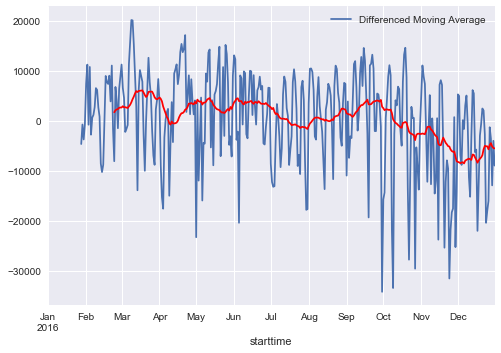

In [13]:
MA_diff2.rename(columns={'ride_count': 'Differenced Moving Average'}).plot()
r = MA_diff2.rolling(window = 28)
r.mean()['ride_count'][28:].plot(color='red', label='Rolling Window: 28 Days')

Both of the MA results seem to have their advantages, but also seem to hover around a mean of zero by a similar amount. There is no clear-cut better option between the two, but that could be calculated by summing the distance of all points from a mean of zero, sort of like a MSE calculation.

## Differencing to Remove Trends and Seasonality
While differencing is done within the ARIMA model, as the integrative portion (I) represents the difference factor. While I could perform a a gridsearch on the ARIMA parameters, I thought that it would be good to difference and then plot the output. Plotting is always a good idea so that you know how stationary your plots appear and what other preprocessing or postprocessing steps need to be done to improve the stationarity of the dataset. For example, the ADF may return a significant value, but there may be a portion of the dataset that is skewing the results.

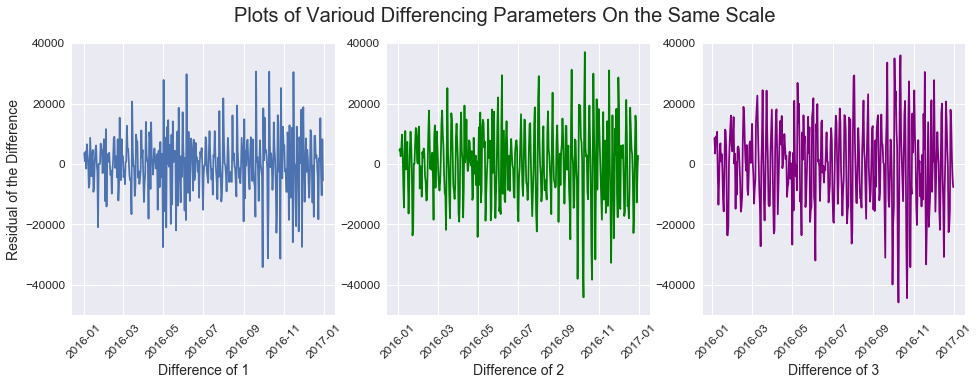

In [55]:
# Let's look at the result of subtracting a shift from the original data
total_DayCounts_diff = total_DayCounts_df - total_DayCounts_df.shift() # Default shifts by one day
# Let's look at the result of subtracting a shift from the original data by two days
total_DayCounts_diff2 = total_DayCounts_df - total_DayCounts_df.shift(periods=2)
# Shift by three days
total_DayCounts_diff3 = total_DayCounts_df - total_DayCounts_df.shift(periods=3)

# Plotting all horizontally
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(16, 5))

plt.subplot(1,3,3)
plt.plot(total_DayCounts_diff3.index, total_DayCounts_diff3, 'purple')
ymin, ymax = plt.gca().get_ylim()
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Difference of 3', fontsize=14)

plt.subplot(1,3,1)
plt.plot(total_DayCounts_diff.index, total_DayCounts_diff)
plt.ylim([ymin, ymax])
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Difference of 1', fontsize=14)
plt.ylabel('Residual of the Difference', fontsize=14)

plt.subplot(1,3,2)
plt.plot(total_DayCounts_diff2.index, total_DayCounts_diff2, 'green')
plt.ylim([ymin, ymax])
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Difference of 2', fontsize=14)
plt.suptitle('Plots of Varioud Differencing Parameters On the Same Scale', fontsize=20)

plt.show()

The result of differencing by a shift of one day is actually really good. Shifting by two days appears to decrease the amount of variance in the plot more than one day, and shifting by three days is similar to that of two days. An explanation for the reason why two or more days is better than one day could be because of the difference in the number of rides that occur on the weekend vs. the weekday. Shifting by a week helps to place the mean around zero, as the weekly seasonality we saw before is reduced to zero.

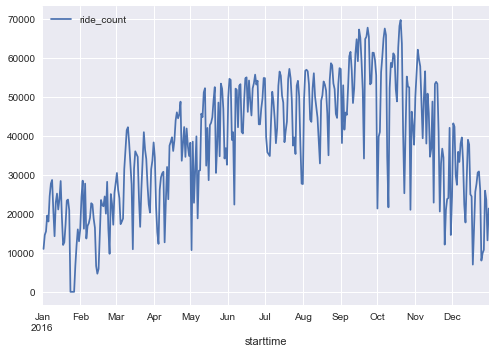

In [18]:
total_DayCounts_df.shift().plot()

## Testing with Augmented Dickey-Fuller (ADF)
Now that we've made some stationary plots, it's time to see which pass the ADF. The ADF is a statistical test called a unit root test. It's called this because the unit root test determines how strongly a time series is defined by a trend. The ADF works by using an autoregressive model and optimizes an information criterion across multiple different lag values. This comes down to the test that the time series can be modeled by a unit root that is not stationary. The alternative is that the series is stationary:
- H0: Non-stationary time series.
- HA: Stationary time series.

The ADF returns a p-value that will indicate whether or not we can reject the null hypothesis. I will be running the ADF on a variety of the transformations that I applied to the original time series to find the transformation that best makes the data stationary. 

In [56]:
# calculate stationarity test of time series data diffrenced by 1
from statsmodels.tsa.stattools import adfuller
X = np.squeeze(total_DayCounts_diff.dropna(axis=0, how='all').values)
result = adfuller(X)
print( 'Difference by 1 ADF Statistic: %f'  % result[0])
print( 'p-value: %f'  % result[1])
print(' Critical Values:' )
for key, value in result[4].items():
  print( '\t%s: %.3f'  % (key, value))

Difference by 1 ADF Statistic: -6.417671
p-value: 0.000000
 Critical Values:
	10%: -2.571
	1%: -3.449
	5%: -2.870


In [57]:
# calculate stationarity test of time series data differenced by 2

X = np.squeeze(total_DayCounts_diff2.dropna(axis=0, how='all').values)
result = adfuller(X)
print( 'Difference by 2 ADF Statistic: %f'  % result[0])
print( 'p-value: %f'  % result[1])
print(' Critical Values:' )
for key, value in result[4].items():
  print( '\t%s: %.3f'  % (key, value))

Difference by 2 ADF Statistic: -6.897730
p-value: 0.000000
 Critical Values:
	10%: -2.571
	1%: -3.449
	5%: -2.870


With a very small p-value and an ADF statistics much less than the 1% threshold, we can safely reject the null hyptohesis that the time series is non-stationary. This is good, as we have satisfied the condition of stationarity and can move on to modeling the data. While stationarity means that I can continue modeling the time series, I may need to come back and make more transformations to get a better series that can better predict than a model that was made stationary by differencing by two days.

It was a nice surprise to find out that simply differencing by a shift of two was able to create a stationary time series.

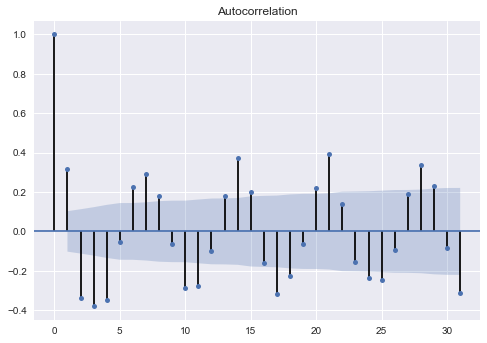

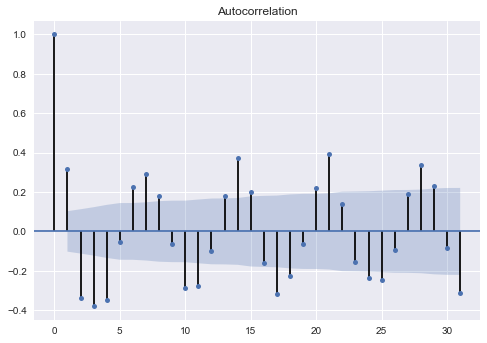

In [22]:
# autocorrelation plot of time series with error bars
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(X, lags=31)

### ACF Results
We see that there is a strong positive correlation between the first, second, and sixth days, and a strong negative correlation between first and third, fourth, and fifth. When I say first, I mean a randomly chosen day in the time series, and its subsequent observations. We have to remember that we are dealing with daily data, which tends to have a trend over subsequent weeks and months. One positive note about this ACF is that a series can be seen as stationary if it has a constant ACF, much like the one we see here.

What this means for the ARIMA model is that the MA parameter (q) will be based off of the first non-seasonal values in the ACF chart. For this model, it appears that the first 4 values are significant, then cuts off and begins a seasonality pattern.

That said, the PACF is better at dealing with harmonic data, as it is 

In [23]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

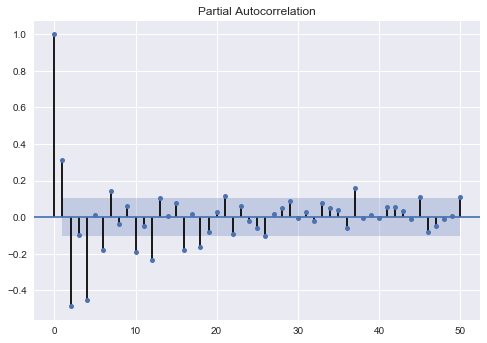

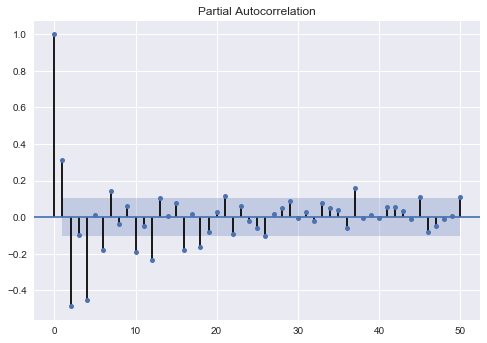

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(X, lags=50)

## PACF Results
The first two values after the self-correlated data point (x=0) are highly significant, as well as the fourth point. There are some points that are 'significant' after these points, but with forecasting models, the simpler the better. As well, some of the recurring significant values could be harmonics of earlier relationships. We want to use the PACF results to determine the autoregressive (AR) coefficient (p). For this model, it appears that a value of 2 is significant. The third lag is barely significant and the fourth is very, so there may be a case to make for a range within p=2-4. However, the danger with a higher order model is overfitting.

## Testing ARIMA Models
Now that we've looked at ACF and PACF for the stationary dataset that was made by differencing by a factor of 2, let's model and evaluate some ARIMA models. We have our p and q values from the previous plots, and a good starting point for the 'd' value is 1, and then test different values after evaluating the error.

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  364
Model:                 ARIMA(4, 2, 2)   Log Likelihood               -3807.956
Method:                       css-mle   S.D. of innovations           8343.185
Date:                Fri, 18 Aug 2017   AIC                           7631.912
Time:                        09:04:03   BIC                           7663.090
Sample:                             2   HQIC                          7644.304
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8998      1.116     -1.702      0.090      -4.088       0.288
ar.L1.D2.y     0.1803      0.097      1.865      0.063      -0.009       0.370
ar.L2.D2.y    -0.1431      0.056     -2.558      0.0

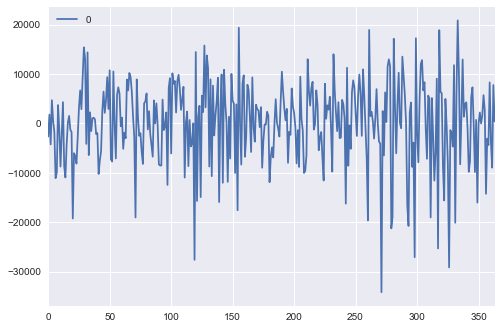

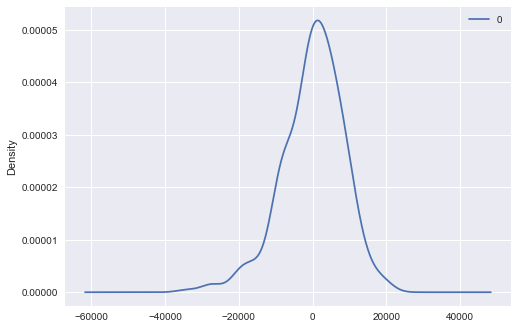

In [26]:
from statsmodels.tsa.arima_model import ARIMA
X = np.squeeze(total_DayCounts_df.dropna(axis=0, how='all').values).astype(float)
# fit model
model = ARIMA(X, order=(4,2,2)) # p,d,q
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
#pyplot.show()
# density plot of residuals
residuals.plot(kind= 'kde' )
#pyplot.show()
# summary stats of residuals
print(residuals.describe())

## Assessment of ARIMA Model
After plotting the density plot of the residuals and assessing the line plot of the residuals, it looks like there is a slight bias in the model, as is indicated by a non-zero mean residual value. While the residual is close, we can see that the bias is probably coming from the spike in variance that was present in the original differenced plot. 

## Using ARIMA Model to Forecast
The ARIMA model can be usd to forecast future time steps by using the `predict()` function on the `ARIMAResults` object to make predictions. It accepts the index of the time steps to make predictions as arguments. The indexes are relative to the start of the training dataset used to make predictions. Therefore, if we used 300 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as `start=301` and `end=301`, which is an array with one element containing the prediction.

To fix any differencing that took place before the model, this can be specified by setting the `typ` argument to the value `'levels': typ='levels'`.

Alternatively, we can avoid these tedious steps by just using the `forecast()` function, whih performs a one-step forecast using the model. We can split the training dataseet into train and test sets, use the train set to model, and generate a prediction for each element on the test set.

In [27]:
# evaluating ARIMA model using a walk-forward validation
from sklearn.metrics import mean_squared_error
# Split data into test and train
size =  int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(4,2,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print( 'predicted=%f, expected=%f'  % (yhat, obs))

predicted=60465.615758, expected=64839.000000
predicted=64601.138959, expected=59202.000000
predicted=58079.569233, expected=67331.000000
predicted=59987.933534, expected=65275.000000
predicted=62165.048139, expected=59200.000000
predicted=60870.010494, expected=51686.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=54250.105639, expected=34217.000000
predicted=45736.472740, expected=64891.000000
predicted=63077.430358, expected=65463.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=68936.061921, expected=67810.000000
predicted=67733.022946, expected=65517.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=55726.849379, expected=53259.000000
predicted=53213.641351, expected=53568.000000
predicted=54459.330670, expected=61386.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=62407.422628, expected=61346.000000
predicted=65755.980953, expected=59464.000000
predicted=60943.034642, expected=55578.000000
predicted=55802.274018, expected=21381.000000
predicted=37150.632394, expected=39811.000000
predicted=44543.049177, expected=41023.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=50837.786285, expected=56384.000000
predicted=62162.273331, expected=60379.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=53227.522637, expected=65053.000000
predicted=54988.961880, expected=67585.000000
predicted=54938.502501, expected=65896.000000
predicted=57675.214072, expected=34625.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=41490.034750, expected=21689.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=32169.045978, expected=52255.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=54901.480943, expected=58768.000000
predicted=68145.359230, expected=57690.000000
predicted=59755.951967, expected=61217.000000
predicted=50100.675952, expected=60566.000000
predicted=52388.557681, expected=51992.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=50391.198342, expected=48870.000000
predicted=49228.716278, expected=62657.000000
predicted=59423.714742, expected=68240.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=65972.235711, expected=69772.000000
predicted=65369.603195, expected=63674.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=58349.982393, expected=40873.000000
predicted=46094.647544, expected=25303.000000
predicted=38014.826547, expected=41463.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=51474.562662, expected=55261.000000
predicted=64417.608938, expected=52681.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=58417.631123, expected=52484.000000
predicted=48380.064245, expected=21058.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=26761.355632, expected=46242.000000
predicted=43898.005402, expected=42514.000000
predicted=47388.905840, expected=37765.000000
predicted=46332.745944, expected=50082.000000
predicted=43267.193931, expected=55967.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=50188.322090, expected=62144.000000
predicted=54060.947255, expected=59641.000000
predicted=50354.738503, expected=57877.000000
predicted=50502.630917, expected=48689.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=47212.916903, expected=39413.000000
predicted=44511.963193, expected=49890.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=52247.877404, expected=56603.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=58748.174125, expected=38060.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=46625.310147, expected=50871.000000
predicted=48416.789499, expected=45832.000000
predicted=46897.014882, expected=34667.000000
predicted=43333.885730, expected=36810.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=39510.034187, expected=48834.000000
predicted=48807.690784, expected=22896.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=35069.530590, expected=53342.000000
predicted=47007.116333, expected=53895.000000
predicted=47700.031848, expected=53390.000000
predicted=51437.733979, expected=41213.000000
predicted=36515.258815, expected=20617.000000
predicted=27828.740378, expected=32972.000000
predicted=36848.536869, expected=36749.000000
predicted=43673.197604, expected=34466.000000
predicted=42484.044005, expected=12122.000000
predicted=22183.534949, expected=20980.000000
predicted=24953.556398, expected=23811.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=28673.321500, expected=24077.000000
predicted=30224.470663, expected=42091.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=34651.719470, expected=14588.000000
predicted=18663.500767, expected=24435.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=21429.357137, expected=43242.000000
predicted=31762.604212, expected=42371.000000
predicted=38905.405467, expected=29854.000000
predicted=26720.074782, expected=27455.000000
predicted=23137.512277, expected=35932.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=32138.418279, expected=33332.000000
predicted=34337.367277, expected=38021.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=35706.880133, expected=39626.000000
predicted=34933.644616, expected=33546.000000
predicted=32671.354968, expected=22379.000000
predicted=25788.705106, expected=17799.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=23798.070680, expected=29037.000000
predicted=31758.919791, expected=39025.000000
predicted=38199.607872, expected=37808.000000
predicted=35168.013533, expected=25015.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=24041.454547, expected=24490.000000
predicted=23325.586866, expected=6993.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16379.032707, expected=16295.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=23385.770324, expected=25649.000000
predicted=27701.016372, expected=27685.000000
predicted=29013.844491, expected=30625.000000
predicted=25139.105482, expected=30889.000000
predicted=23812.023799, expected=26343.000000
predicted=22476.171191, expected=8014.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13040.156304, expected=9924.000000


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15110.992118, expected=10775.000000
predicted=17610.562840, expected=25955.000000
predicted=27393.864452, expected=23601.000000
predicted=22262.983404, expected=13206.000000
predicted=13438.418692, expected=21375.000000
predicted=15486.649086, expected=15928.000000


Test RMSE: 10929.737


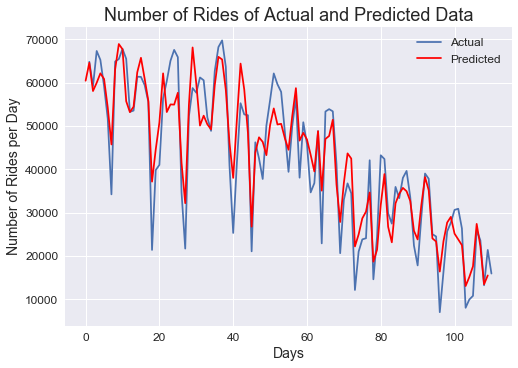

In [66]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(range(1,1+len(test)), test, label='Actual') #Should this be shifted along x-axis by one? range(1,1+len(test))
plt.plot(predictions, color='red', label='Predicted')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Rides per Day', fontsize=14)
plt.title('Number of Rides of Actual and Predicted Data', fontsize=18)
plt.legend(fontsize=12)
plt.show()


Not bad for a first try! We can see both large and small trends are followed to a degree, and that the large variance that would be encountered in the last 30% of the dataset was followed quite well. Of course, the trend could be better if the variance around index 20, which corresponds roughly with the steep decline in demand, was better filtered in the original attempt to make the series stationary.

## Gridsearch for ARIMA Hyperparameters
Recall that there were a range of values for which the ARIMA model may work. There were 2 p-values, 3 q-values, and 3 distinct d-values (1,2,7) where a global optimum could be found. Let's explore them all with a gridsearch and return the model with the best results. This calculation will take a while.

I'll create and use a function to evaluate an ARIMA models so that I can quickly iterate over different ARIMA parameters.

In [29]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.7)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

This is going to get a little messy, so disable filter warnings.

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype(float)
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                #rmse = evaluate_arima_model(dataset, order)
                #if rmse < best_score:
                #    best_score, best_cfg = rmse, order
                #print(' ARIMA %s RMSE=%.3f'  % (order,rmse))
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print(' ARIMA %s RMSE=%.3f'  % (order,rmse))
                except:
                    continue
    print('Best ARIMA %s RMSE=%.3f ' % (best_cfg, best_score))

In [32]:
# evaluate parameters
p_values = [0, 1, 2, 4]
d_values = [1,2,7]
q_values = [0,1,2,3,4]
#q_values = [0,1,3,4]
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

 ARIMA (0, 1, 0) RMSE=12387.019
 ARIMA (0, 1, 1) RMSE=12162.234
 ARIMA (0, 1, 2) RMSE=11057.354
 ARIMA (0, 1, 3) RMSE=11157.907
 ARIMA (0, 2, 0) RMSE=18924.120
 ARIMA (0, 2, 1) RMSE=12434.870
 ARIMA (1, 1, 0) RMSE=12268.689
 ARIMA (1, 1, 1) RMSE=11249.672
 ARIMA (1, 2, 0) RMSE=16601.695
 ARIMA (2, 1, 0) RMSE=12051.591
 ARIMA (2, 1, 2) RMSE=11029.337
 ARIMA (2, 2, 0) RMSE=15561.710
 ARIMA (4, 1, 0) RMSE=11252.396
 ARIMA (4, 1, 1) RMSE=10951.770
 ARIMA (4, 2, 0) RMSE=14201.935
 ARIMA (4, 2, 2) RMSE=10929.737
Best ARIMA (4, 2, 2) RMSE=10929.737 


So, the ARIMA model won't even look at a difference of 7! Under the hood, this difference doesn't allow the ARIMA model to converge, which is why we simply skip error steps with the try/except statements. Also, it looks like my intuition was correct from looking at the the ACF and PACF graphs. An ARIMA model with a (4,2,2) set of parameters was the optimal model, barely beating out a (4,1,1) configuration. I can 